# Domain adaptation

In [1]:
from pathlib import Path
DATASET_ZIP_PATH = '/tmp/Adaptiope.zip'
DATASET_EXTRACTION_PATH = '/tmp/Adaptiope'
DATASET_PATH = Path('./data/adaptiope_small')

## Dataset extraction

In [2]:
from os import makedirs
from os.path import join, isdir
from shutil import copytree

In [3]:
!mkdir -p {DATASET_EXTRACTION_PATH}
!unzip -d {DATASET_EXTRACTION_PATH} {DATASET_ZIP_PATH}

unzip:  cannot find or open /tmp/Adaptiope.zip, /tmp/Adaptiope.zip.zip or /tmp/Adaptiope.zip.ZIP.


In [4]:
if not isdir(DATASET_PATH):
    classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
               "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
               "purse", "stand mixer", "stroller"]
    for d, td in zip([
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/product_images",
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/real_life"],[
        f"{DATASET_PATH}/product_images",
        f"{DATASET_PATH}/real_life"]):
        makedirs(td)
        for c in classes:
            c_path = join(d, c)
            c_target = join(td, c)
            copytree(c_path, c_target)

## Dataset exploration

In [5]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [6]:
dataset = ImageFolder(DATASET_PATH / "product_images")
idx_to_class = {v: k for k,v in dataset.class_to_idx.items()}

In [7]:
# imgs: List[str, int] path, class
seen_classes = set()
imgs = []
for i, (p, c) in enumerate(dataset.imgs):
    if c not in seen_classes:
        seen_classes.add(c)
        imgs.append(i)

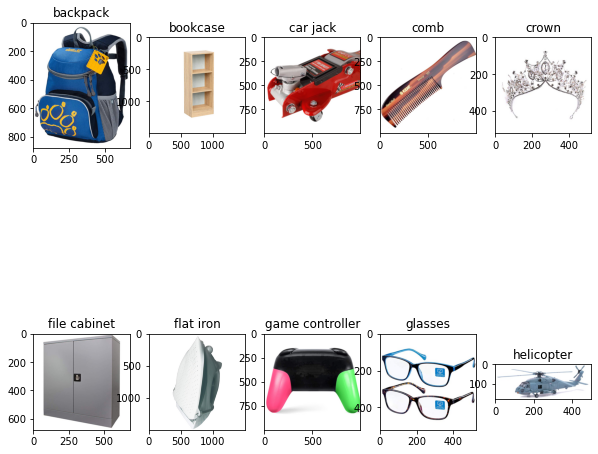

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(10,10))
for i in range(2):
    for j in range(5):
        image, title = dataset[imgs.pop(0)]
        axs[i,j].imshow(image)
        axs[i,j].set_title(idx_to_class[title])

## Utility functions

In [9]:
import random
import numpy as np
import torch

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

def set_random_seed(seed=0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def print_epoch_chart(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    epoch,
    num_epochs
):
    clear_output(wait=True)
    
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(15,7))
    x = np.arange(len(train_losses))
    loss_ax.plot(x, train_losses, label='train')
    loss_ax.plot(x, val_losses, label='validation')
    loss_ax.set_title("Loss")
    loss_ax.set_ylim([0, 5])
    loss_ax.legend()
    acc_ax.plot(x, train_acc, label='train')
    acc_ax.plot(x, val_acc, label='validation')
    acc_ax.set_title("Accuracy")
    acc_ax.legend()
    fig.suptitle(f"Epoch {epoch+1} of {num_epochs}")
    plt.show()

## Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models


class CustomModel(nn.Module):
    def __init__(self, num_classes: int, feature_dimension: int, dropout_rate: float) -> None:
        super().__init__()
        self.feature_extractor = models.resnet34(pretrained=True)
        #self.feature_extractor = models.alexnet(pretrained=True)
        #self.feature_extractor.avgpool = nn.AdaptiveAvgPool2d(1)
        #self.dropout_rate = dropout_rate

        out_feature_extractor = self.feature_extractor.fc.in_features
        #out_feature_extractor = self.feature_extractor.classifier[6].in_features
        

        #for param in self.feature_extractor.parameters():
        #    param.requires_grad = True

        self.feature_extractor.fc =  nn.Sequential(
            nn.Linear(out_feature_extractor, num_classes),
            #nn.Linear(out_feature_extractor, feature_dimension),
            #nn.ReLU(),
            #nn.Linear(feature_dimension, feature_dimension // 2),
            #nn.ReLU(),
            #nn.Linear(feature_dimension // 2, num_classes),
        )
        #self.feature_extractor.classifier[6] =  nn.Linear(out_feature_extractor, num_classes)
        

        #init_modules = [
#            self.feature_extractor.fc,
        #]

        #for m in init_modules:
        #    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        #        nn.init.kaiming_normal_(m.weight.data)
        #        if m.bias is not None:
        #            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        return self.feature_extractor(x)

## Dataset

In [11]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from torch.utils.data import DataLoader, random_split

In [12]:
dataset = ImageFolder(
    DATASET_PATH / "product_images",
    transform=T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

validation_ratio = .2
test_ratio = .2

validation_dataset, test_dataset, train_dataset = random_split(
    dataset,
    [
        int(len(dataset)*validation_ratio),
        int(len(dataset)*test_ratio),
        len(dataset) - (
            int(len(dataset)*validation_ratio)
            +int(len(dataset)*test_ratio)
        )
    ]
)

In [13]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(1200, 400, 400)

## Train

In [14]:
from torch.optim import lr_scheduler, SGD, Adam

from tqdm import tqdm
#import torchinfo

In [15]:
# misc
set_random_seed(33)
device = get_device()
num_threads = 4

# train
num_epochs = 15
batch_size = 64
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20

In [16]:
def get_data_loader(dataset, batch_size, num_threads):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_threads
    )
def get_optimizer(model, lr, wd, momentum):

    # we will create two groups of weights, one for the newly initialized layer
    # and the other for rest of the layers of the network

    final_layer_weights = []
    rest_of_the_net_weights = []

    # we will iterate through the layers of the network
    for name, param in model.named_parameters():
        if name.startswith('feature_extractor.fc'):
        #if name.startswith('feature_extractor.classifier.6'):
            final_layer_weights.append(param)
        else:
            rest_of_the_net_weights.append(param)

    # so now we have divided the network weights into two groups.
    # We will train the final_layer_weights with learning_rate = lr
    # and rest_of_the_net_weights with learning_rate = lr / 10

    optimizer = torch.optim.SGD([
      {'params': rest_of_the_net_weights},
      {'params': final_layer_weights, 'lr': lr}
    ], lr=lr / 10, weight_decay=wd, momentum=momentum)

    return optimizer

In [17]:
def initialize_alexnet(num_classes):
    # load the pre-trained Alexnet
    alexnet = models.alexnet(pretrained=True)

    # get the number of neurons in the penultimate layer
    in_features = alexnet.classifier[6].in_features

    # re-initalize the output layer
    alexnet.classifier[6] = torch.nn.Linear(in_features=in_features, 
                                          out_features=num_classes)

    return alexnet

In [18]:
#model = CustomModel(len(dataset.classes), 1024, 0.2)
#for name, param in model.named_parameters():
#    print(name)

In [19]:
#model = initialize_alexnet(len(dataset.classes))
#print([i[0] for i in model.named_parameters()])

In [20]:
model = CustomModel(len(dataset.classes), 1024, 0.2)
#model = initialize_alexnet(len(dataset.classes))
model.to(device)
optimizer = get_optimizer(model, lr, weight_decay, momentum)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=scheduler_factor,
    patience=scheduler_patience,
    verbose=True
) 
dataloaders = {
    'train': get_data_loader(train_dataset, batch_size, num_threads),
    'validation': get_data_loader(validation_dataset, batch_size, num_threads),
    #'test': get_data_loader(test_dataset, batch_size, num_threads)
}
#summary(model, input_size=(batch_size, *dataset[0][0].size()))

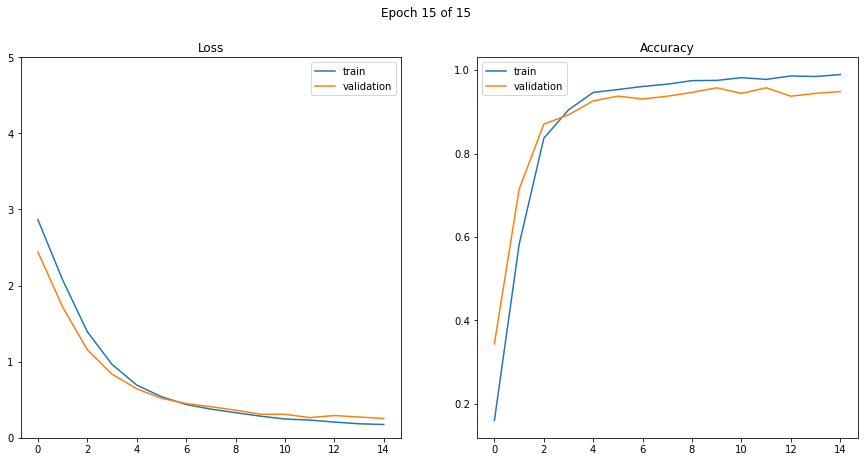

In [21]:
best_model = model
best_loss = np.Inf

phases_loss = {k: [] for k in dataloaders.keys()}
phases_acc = {k: [] for k in dataloaders.keys()}
for epoch in range(num_epochs):
    for phase, dataloader in dataloaders.items():
        if phase == "train":
            model.train()
        else:
            model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        for index, (x, labels) in enumerate(dataloader):
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.autocast(device_type=device.type):
                with torch.set_grad_enabled(phase == "train"):
                    predictions = model(x)
                    loss = criterion(predictions, labels)
                    epoch_loss += loss.item()
                    epoch_acc += (torch.argmax(predictions, 1) == labels).sum().item() / labels.size()[0]

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

        epoch_loss /= len(dataloader)
        epoch_acc /= len(dataloader)
        phases_loss[phase].append(epoch_loss)
        phases_acc[phase].append(epoch_acc)

        if phase == "validation" and abs(epoch_loss) <= abs(best_loss):
            best_model = model
            best_loss = epoch_loss
            scheduler.step(epoch_loss)
            
    print_epoch_chart(
        phases_loss['train'],
        phases_loss['validation'],
        phases_acc['train'],
        phases_acc['validation'],
        epoch,
        num_epochs
    )

### Test model

In [22]:
predictions = []
reals = []
for x, y in test_dataset:
    x_gpu = x.unsqueeze(0).to(device)
    predicted = best_model(x_gpu)
    predictions.append(np.argmax(predicted.detach().cpu().numpy()))
    reals.append(y)
    del x_gpu
predictions = np.array(predictions)
reals = np.array(reals)

In [23]:
def plot_predictions(index, idx_to_class, dataset, reals, predictions):
    x, _ = dataset[index]
    plt.imshow(x[1])
    print(idx_to_class[reals[index]], idx_to_class[predictions[index]])

crown crown


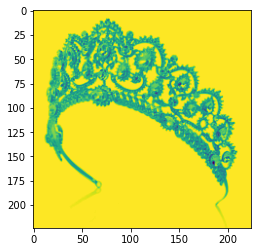

In [24]:
plot_predictions(350, idx_to_class, test_dataset, reals, predictions) 

In [25]:
(reals == predictions).sum() / reals.shape[0]

0.9625

## Domain adaptation

In [26]:
dataset = ImageFolder(
    DATASET_PATH / "real_life",
    transform=T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [27]:
predictions = []
reals = []
for x, y in dataset:
    x_gpu = x.unsqueeze(0).to(device)
    predicted = best_model(x_gpu)
    predictions.append(np.argmax(predicted.detach().cpu().numpy()))
    reals.append(y)
    del x_gpu
predictions = np.array(predictions)
reals = np.array(reals)

In [28]:
def plot_predictions(index, idx_to_class, dataset, reals, predictions):
    x, _ = dataset[index]
    plt.imshow(x[1])
    print(idx_to_class[reals[index]], idx_to_class[predictions[index]])

comb comb


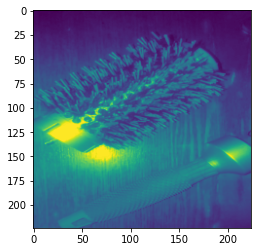

In [29]:
plot_predictions(350, idx_to_class, dataset, reals, predictions) 

In [30]:
(reals == predictions).sum() / reals.shape[0]

0.765